In [2]:
import os
import spacy
import warnings
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go


import numpy as np
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import textstat
import spacy
nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize 

import warnings
warnings.filterwarnings("ignore")

import contractions
import nltk
import string

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
import pkg_resources
from symspellpy import SymSpell, Verbosity

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
patient_notes = pd.read_csv("patient_notes.csv")
#one case number has many pn_num
features = pd.read_csv("features.csv")
#one case has many feature_num
train = pd.read_csv("train.csv")

train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')

pd.set_option('display.max_colwidth', None)
display(train.head(2))

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"


## Pre-processing the text column to clean it 

In [3]:
train["pn_history_lower"] = train["pn_history"].str.lower()
regex = re.compile(r'<[^>]+>')
train["pn_history_noContractions"] = train["pn_history_lower"].apply(contractions.fix)

def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text
train["pn_history_noUnicode"] = train["pn_history_noContractions"].apply(remove_unicode_chars)

def remove_punctuations(text):
    custom_punctuations = "".join([elem for elem in string.punctuation if elem not in [',', '.']])
    text = re.sub('[%s]' % re.escape(custom_punctuations), " ",text)
    return text
train["pn_history_noPuncts"] = train["pn_history_noUnicode"].apply(remove_punctuations)

#def remove_stopwords(text):
#    return " ".join([word for word in str(text).split() if word not in stop_words])
#train["tweet_noStopwords"] = train["tweet_noPuncts"].apply(remove_stopwords)
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text
train["pn_history_noES"] = train["pn_history_noPuncts"].apply(remove_extra_spaces)
def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text
train["pn_history_preprocessed"] = train["pn_history_noES"].apply(lemmatize_text)

In [5]:
train = train.drop_duplicates(["pn_history_preprocessed"])

## Model 5 : KeyBert with biomedical-ner-all

In [7]:
from keybert import KeyBERT
from tqdm import tqdm

In [8]:
model = KeyBERT(model="d4data/biomedical-ner-all")

No sentence-transformers model found with name /Users/aishwariyagupta/.cache/torch/sentence_transformers/d4data_biomedical-ner-all. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/aishwariyagupta/.cache/torch/sentence_transformers/d4data_biomedical-ner-all were not used when initializing DistilBertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Applying KEYBERT Model

### Extracting 2 keywords

In [11]:
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3, 
                keyphrase_ngram_range=(1, 2),
                use_mmr=True, 
                diversity=0.7))

1000it [10:44,  1.55it/s]


In [12]:
train = train.reset_index(drop=True)

In [13]:
train = train.join(pd.DataFrame(l, columns=['first_keyword', 'second_keyword', 'third_keyword']))

In [15]:
train.to_csv("two_keywords_extraction_biomedical-ner-all.csv")

In [16]:
#seprating keyword along with cosine similarity
def func(x):
    return x[1]
train['first_keyword_score'] = train.first_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['first_keyword'] = train.first_keyword.apply(lambda x: func(x))

def func(x):
    return x[1]
train['second_keyword_score'] = train.second_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['second_keyword'] = train.second_keyword.apply(lambda x: func(x))

def func(x):
    return x[1]
train['third_keyword_score'] = train.third_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['third_keyword'] = train.third_keyword.apply(lambda x: func(x))

In [17]:
train.to_csv("two_keywords_extraction_with_score_biomedical-ner-all.csv")

## Extracting 3 keywords

In [18]:

l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3,
                keyphrase_ngram_range=(1, 3),
                use_mmr=True, 
                diversity=0.7))

1000it [15:26,  1.08it/s]


In [19]:
train_new = train.join(pd.DataFrame(l, columns=['first_keyword_three', 'second_keyword_three', 'third_keyword_three']))

In [20]:
train.to_csv("three_keywords_extraction_biomedical-ner-all.csv")

In [21]:
def func(x):
    return x[1]
train_new['first_keyword_score_three'] = train_new.first_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['first_keyword_three'] = train_new.first_keyword_three.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new['second_keyword_score_three'] = train_new.second_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['second_keyword_three'] = train_new.second_keyword_three.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new['third_keyword_score_three'] = train_new.third_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['third_keyword_three'] = train_new.third_keyword_three.apply(lambda x: func(x))

In [22]:
train.to_csv("three_keywords_extraction_with_score_biomedical-ner-all.csv")

## Extracting 4 keywords

In [23]:
#extracting 4 keywords
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3,
                keyphrase_ngram_range=(1, 4),
                use_mmr=True, 
                diversity=0.7))

1000it [20:43,  1.24s/it]


In [24]:
train_new['third_keyword_score_three'] = train_new['third_keyword_score']

In [25]:
train_new_new = train_new.join(pd.DataFrame(l, columns=['first_keyword_four', 'second_keyword_four', 'third_keyword_four']))


In [26]:
train_new_new.to_csv("four_keywords_extraction_biomedical-ner-all.csv")

In [27]:
def func(x):
    return x[1]
train_new_new['first_keyword_score_four'] = train_new_new.first_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['first_keyword_four'] = train_new_new.first_keyword_four.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new_new['second_keyword_score_four'] = train_new_new.second_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['second_keyword_four'] = train_new_new.second_keyword_four.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new_new['third_keyword_score_four'] = train_new_new.third_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['third_keyword_four'] = train_new_new.third_keyword_four.apply(lambda x: func(x))

In [28]:
train_new_new.to_csv("all_keywords_with_score_biomedical-ner-all.csv")

In [30]:
train_with_scores = train_new_new.copy()

In [31]:
train_with_scores = pd.read_csv("all_keywords_with_score_biomedical-ner-all.csv")

In [32]:
train_with_scores = train_with_scores[['id', 'case_num', 'pn_num', 'feature_num', 'annotation', 'location', 'feature_text', 'pn_history', 'pn_history_lower', 'pn_history_noContractions', 'pn_history_noUnicode', 'pn_history_noPuncts', 'pn_history_noES', 'pn_history_preprocessed', 'first_keyword', 'second_keyword', 'third_keyword', 'first_keyword_score', 'second_keyword_score', 'third_keyword_score', 'first_keyword_three', 'second_keyword_three', 'third_keyword_three', 'first_keyword_score_three', 'second_keyword_score_three', 'third_keyword_score_three', 'first_keyword_four', 'second_keyword_four', 'third_keyword_four', 'first_keyword_score_four', 'second_keyword_score_four', 'third_keyword_score_four']]

In [34]:
train_with_scores = train_with_scores.iloc[:,14:]

In [35]:
train_with_scores.first_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.703775
0.50    0.745100
0.75    0.777500
0.90    0.811800
Name: first_keyword_score, dtype: float64

In [36]:
train_with_scores.second_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.157050
0.50    0.216400
0.75    0.279275
0.90    0.338260
Name: second_keyword_score, dtype: float64

In [37]:
train_with_scores.third_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25   -0.036700
0.50    0.021450
0.75    0.093025
0.90    0.160360
Name: third_keyword_score, dtype: float64

### selecting those keywords which have a cosine similarity more than 0.25

In [38]:
train_with_scores.first_keyword = np.where(train_with_scores.first_keyword_score > 0.25, train_with_scores.first_keyword, np.nan)
train_with_scores.second_keyword = np.where(train_with_scores.second_keyword_score > 0.25, train_with_scores.second_keyword, np.nan)
train_with_scores.third_keyword = np.where(train_with_scores.third_keyword_score > 0.25, train_with_scores.third_keyword, np.nan)

In [39]:
train_with_scores.first_keyword_score.median(), train_with_scores.second_keyword_score.median(), train_with_scores.third_keyword_score.median()


(0.7451, 0.2164, 0.021449999999999997)

In [40]:
train_with_scores.first_keyword_three = np.where(train_with_scores.first_keyword_score_three > 0.25, train_with_scores.first_keyword_three, np.nan)
train_with_scores.second_keyword_three = np.where(train_with_scores.second_keyword_score_three > 0.25, train_with_scores.second_keyword_three, np.nan)
train_with_scores.third_keyword_three = np.where(train_with_scores.third_keyword_score_three > 0.25, train_with_scores.third_keyword_three, np.nan)


In [41]:
train_with_scores.first_keyword_four = np.where(train_with_scores.first_keyword_score_four > 0.25, train_with_scores.first_keyword_four, np.nan)
train_with_scores.second_keyword_four = np.where(train_with_scores.second_keyword_score_four > 0.25, train_with_scores.second_keyword_four, np.nan)
train_with_scores.third_keyword_four = np.where(train_with_scores.third_keyword_score_four > 0.25, train_with_scores.third_keyword_four, np.nan)


In [42]:
train_new_new = pd.read_csv("all_keywords_with_score_biomedical-ner-all.csv")

In [43]:
train_with_scores = train_new_new[['id', 'pn_num', 'pn_history_preprocessed']].join(train_with_scores)

In [44]:
train_with_scores[:1].third_keyword.values

array([nan], dtype=object)

### Predicting Annotations

In [45]:
def func(x):
    all_annotation = []
    for annotation in [x.first_keyword, x.second_keyword, x.third_keyword, 
                       x.first_keyword_three, x.second_keyword_three, x.third_keyword_three,
                       x.first_keyword_four, x.second_keyword_four, x.third_keyword_four]:
        
        if str(annotation) != 'nan':
            all_annotation.append(str(annotation))
    return list(set(all_annotation))
    
train_with_scores['predicted_annotation'] = train_with_scores.apply(lambda x: func(x), axis=1)

In [46]:
train_with_scores[['pn_num', 'predicted_annotation']]

,pn_num,predicted_annotation
0,16,"[breath diaphoresis, patient endorses abusing, endorses abusing, note patient endorses abusing]"
1,41,"[stds using, denies cough, fh mom ha thyroid, recently denies cough]"
2,46,"[anxiousness starting school, anxiousness starting]"
3,82,"[episode patient experienced light, patient experienced light, report adverse]"
4,100,"[months endorses light, intermittent tachycardia, endorses light]"
...,...,...
995,95145,"[worst headache, state worst headache life, progressively getthing worse]"
996,95228,"[ha severe headache, headache photosensitivity, ha severe, apartment ha severe headache, photosensitivity x2]"
997,95243,"[headache patient said, patient said, headache patient said started]"
998,95330,"[presenting worst ha, presenting worst]"


In [47]:
train_with_scores.to_csv("final_annotationsbiomedical-ner-all.csv")

In [4]:
#train_with_scores.to_csv("final_annotations")
train_with_scores = pd.read_csv("final_annotationsbiomedical-ner-all.csv",index_col=[0])

In [5]:
from thefuzz import fuzz
from thefuzz import process

In [6]:
patient_notes_test = pd.read_csv("patient_notes.csv")
#one case number has many pn_num
features_test = pd.read_csv("features.csv")
#one case has many feature_num
test = pd.read_csv("train.csv")
test = test.merge(features_test, on=['feature_num', 'case_num'], how='left')
test = test.merge(patient_notes_test, on=['pn_num', 'case_num'], how='left')
test = test.merge(train_with_scores[['pn_num', 'pn_history_preprocessed']], on=['pn_num'], how='left')
pd.set_option('display.max_colwidth', None)
display(test.head(2))

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,pn_history_preprocessed
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms","hpi 17yo m present with palpitations. patient report 3 4 month of intermittent episode of heart beating pounding out of my chest. 2 day ago during a soccer game had an episode, but this time had chest pressure and felt a if he were going to pas out did not lose conciousness . of note patient endorses abusing adderall, primarily to study 1 3 time per week . before recent soccer game, took adderrall night before and morning of game. denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, change in sleep, change in vision hearing, abdominal paun, change in bowel or urinary habits. pmhx none rx us friend adderrall fhx mom with thyroid disease, dad with recent heart attcak all none immunization up to date shx freshman in college. endorses 3 4 drink 3 night week on weekend , denies tabacco, endorses trying marijuana. sexually active with girlfriend x 1 year, us condom"
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms","hpi 17yo m present with palpitations. patient report 3 4 month of intermittent episode of heart beating pounding out of my chest. 2 day ago during a soccer game had an episode, but this time had chest pressure and felt a if he were going to pas out did not lose conciousness . of note patient endorses abusing adderall, primarily to study 1 3 time per week . before recent soccer game, took adderrall night before and morning of game. denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, change in sleep, change in vision hearing, abdominal paun, change in bowel or urinary habits. pmhx none rx us friend adderrall fhx mom with thyroid disease, dad with recent heart attcak all none immunization up to date shx freshman in college. endorses 3 4 drink 3 night week on weekend , denies tabacco, endorses trying marijuana. sexually active wi

In [7]:
test = test.merge(train_with_scores[['pn_num', 'predicted_annotation']], how='left', on='pn_num')

In [8]:
evaluation = test[['pn_num', 'annotation', 'predicted_annotation', 'pn_history', 'pn_history_preprocessed']]
evaluation = evaluation[evaluation.annotation != '[]']
evaluation['annotation'] = evaluation['annotation'].astype(str)
evaluation['ground_truth_annotation'] = evaluation.annotation.apply(lambda x: eval(x))
evaluation = evaluation.explode('ground_truth_annotation')
evaluation['ground_truth_annotation_junk'] = evaluation.ground_truth_annotation.apply(lambda x: len(str(x)) < 3)

In [9]:
evaluation = evaluation.drop_duplicates()

In [10]:
evaluation.ground_truth_annotation_junk.value_counts(normalize=True)

False    0.940796
True     0.059204
Name: ground_truth_annotation_junk, dtype: float64

In [11]:
evaluation_pp = evaluation.copy()

## Evaluation

In [12]:
evaluation['predicted_annotation'] = evaluation['predicted_annotation'].astype(str)
evaluation = evaluation[evaluation.predicted_annotation != '[]']
evaluation['prediction'] = evaluation.predicted_annotation.apply(lambda x: eval(x))
evaluation = evaluation.explode('prediction')

## Selecting columns of interest to calculate the evaluation

In [13]:
cols = ['pn_num', 
       'pn_history_preprocessed', 
       'ground_truth_annotation',
       'prediction']
evaluation = evaluation[cols]

## Evaluation Phase 1 : Getting the fuzzy wuzzy score

In [14]:
def get_fuzzy_wuzzy_score(x):
    prediction = x['prediction']
    label = x['ground_truth_annotation']
    return fuzz.partial_ratio(prediction, label)

evaluation['score'] = evaluation.apply(lambda x: get_fuzzy_wuzzy_score(x), axis=1)

<AxesSubplot:xlabel='score'>

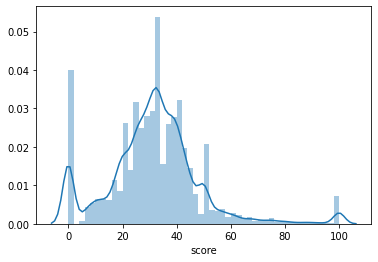

In [15]:
sns.distplot(evaluation.score)

## Precision

In [16]:
def relevance(x, threshold):
    all_predictions = x.groupby(['prediction']).agg({'score': 'max'}).reset_index()
    found_predictions = len(all_predictions[all_predictions['score'] >= threshold])
    return found_predictions, len(all_predictions)

In [17]:
threshold_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
all_relevant_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    relevant_predictions = evaluation.groupby(['pn_num']).apply(lambda x: relevance(x, threshold=threshold_val))
    relevant_predictions = relevant_predictions.reset_index()
    relevant_predictions = pd.DataFrame(relevant_predictions[0].tolist(), index=relevant_predictions.pn_num)\
                            .rename(columns={0:f'found_labels', 1:f'total_predictions'})\
                            .reset_index()
    relevant_predictions[f'precision'] = relevant_predictions[f'found_labels'] / relevant_predictions[f'total_predictions']
    relevant_predictions['threshold'] = threshold_val
    all_relevant_predictions = pd.concat([all_relevant_predictions, relevant_predictions], axis=0)

## Recall

In [18]:
def retrieval(x, threshold):
    all_labels = x.groupby(['ground_truth_annotation']).agg({'score': 'max'}).reset_index()
    found_labels = len(all_labels[all_labels['score'] >= threshold])
    total_predictions = x['prediction'].nunique()
    
    return found_labels, len(all_labels)

In [19]:
threshold_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
all_retrieved_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    retrieved_labels = evaluation.groupby(['pn_num']).apply(lambda x: retrieval(x, threshold=threshold_val))
    retrieved_labels = retrieved_labels.reset_index()
    retrieved_labels = pd.DataFrame(retrieved_labels[0].tolist(), index=retrieved_labels.pn_num)\
                        .rename(columns={0:f'found_predictions', 1:f'total_labels'})\
                        .reset_index()
    retrieved_labels['recall'] = retrieved_labels[f'found_predictions'] / retrieved_labels[f'total_labels']
    retrieved_labels['threshold'] = threshold_val
    all_retrieved_predictions = pd.concat([all_retrieved_predictions, retrieved_labels], axis=0)

In [20]:
evaluation_df = all_retrieved_predictions.merge(all_relevant_predictions, how='left', on=['pn_num', 'threshold'])
evaluation_df = evaluation_df[['pn_num', 'threshold', 'total_labels', 'total_predictions', 'found_labels', 'found_predictions', 'recall', 'precision']]

evaluation_df['f1_score'] = 2 * (evaluation_df['recall'] * evaluation_df['precision']) / (evaluation_df['recall'] + evaluation_df['precision'])
evaluation_df

,pn_num,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,16,10,13,4,4,12,0.923077,1.0,0.960000
1,41,10,9,4,4,7,0.777778,1.0,0.875000
2,46,10,12,2,2,10,0.833333,1.0,0.909091
3,82,10,13,3,3,12,0.923077,1.0,0.960000
4,100,10,10,3,3,10,1.000000,1.0,1.000000
...,...,...,...,...,...,...,...,...,...
9995,95145,100,12,3,0,0,0.000000,0.0,NaN
9996,95228,100,7,5,2,1,0.142857,0.4,0.210526
9997,95243,100,10,3,0,0,0.000000,0.0,NaN
9998,95330,100,16,2,0,0,0.000000,0.0,NaN


In [21]:
evaluation_df[evaluation_df.pn_num==16]

,pn_num,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,16,10,13,4,4,12,0.923077,1.0,0.960000
1000,16,20,13,4,4,12,0.923077,1.0,0.960000
2000,16,30,13,4,4,11,0.846154,1.0,0.916667
3000,16,40,13,4,4,8,0.615385,1.0,0.761905
4000,16,50,13,4,2,3,0.230769,0.5,0.315789
5000,16,60,13,4,0,0,0.000000,0.0,NaN
6000,16,70,13,4,0,0,0.000000,0.0,NaN
7000,16,80,13,4,0,0,0.000000,0.0,NaN
8000,16,90,13,4,0,0,0.000000,0.0,NaN
9000,16,100,13,4,0,0,0.000000,0.0,NaN


In [22]:
biomedical_ner_all_evaluation = evaluation_df.merge(test,on="pn_num",how="left")

In [23]:
biomedical_ner_all_evaluation.to_csv("biomedical_ner_all_evaluation.csv", index=False)

In [24]:
evaluation_df.to_csv("biomedical_ner_all_evaluation_scores.csv",index=False)

In [1]:
import pandas as pd
evaluation = pd.read_csv("biomedical_ner_all_evaluation_scores.csv")

In [2]:
evaluation[(evaluation.pn_num == 95333)]

,pn_num,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
999,95333,10,11,2,2,11,1.000000,1.0,1.000000
1999,95333,20,11,2,2,10,0.909091,1.0,0.952381
2999,95333,30,11,2,2,8,0.727273,1.0,0.842105
3999,95333,40,11,2,2,3,0.272727,1.0,0.428571
4999,95333,50,11,2,2,3,0.272727,1.0,0.428571
5999,95333,60,11,2,2,1,0.090909,1.0,0.166667
6999,95333,70,11,2,2,1,0.090909,1.0,0.166667
7999,95333,80,11,2,2,1,0.090909,1.0,0.166667
8999,95333,90,11,2,2,1,0.090909,1.0,0.166667
9999,95333,100,11,2,2,1,0.090909,1.0,0.166667
